In [1]:
# Import packages
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from PIL import Image
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
print(device)
torch.manual_seed(189898)

cuda


## Part 1: (5 pts)
Load the CIFAR10 dataset and display one image of each class. Set up your dataloader using torchvision.transforms. Take into account the required preprocessing transformations expected by the model (ResNet18). Additionally include a data augmentation strategy and report it.

In [2]:
# Fix certificate errors
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
# Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
# Download the dataset and display classes
transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root="../data", train=True, download=False, transform=transform_flip)
test_dataset = torchvision.datasets.CIFAR10(root="../data", train=False, transform=preprocess)
classes = trainset.class_to_idx
print(classes)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [4]:
# Print the dataset shape
trainset.data.shape

(50000, 32, 32, 3)

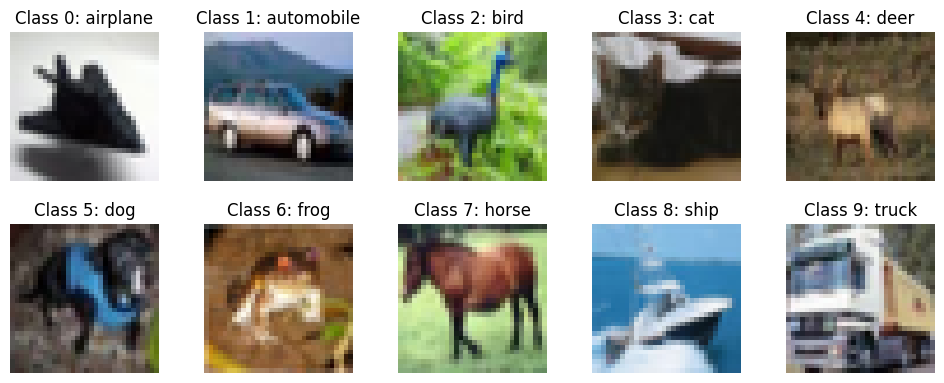

In [5]:
# Get the index of one image from each class
class_names = []
for c in classes:
    class_names.append(c)
indices = [-1 for i in range(10)]
for i, (image, label) in enumerate(trainset):
    if indices[label] < 0:
        indices[label] = i

# Display one image from each class
fig, axs = plt.subplots(2, 5, figsize=(10,4))
fig.tight_layout(h_pad=1, w_pad=0)
for i, index in enumerate(indices):
    if i <= 4:
        row = 0
        col = i
    else:
        row = 1
        col = i - 5
    axs[row,col].imshow(trainset.data[index])
    axs[row,col].set_title(f"Class {trainset.targets[index]}: {class_names[i]}")
    axs[row,col].axis('off')

In [6]:
# Set up the dataloader
batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Part 2: (5 pts)
Download an image of any of the classes present in the ImageNet dataset and make sure the pretrained model is able to classify it correctly. Then, try a transformation or noise injection that can trick the network.

In [7]:
# import the pretrained model and send it to device
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# get the ImageNet labels
with open('../data/imagenet_classes.txt') as f:
    imagenet_labels = [line.strip() for line in f.readlines()]
imagenet_labels

['0, tench',
 '1, goldfish',
 '2, great_white_shark',
 '3, tiger_shark',
 '4, hammerhead',
 '5, electric_ray',
 '6, stingray',
 '7, cock',
 '8, hen',
 '9, ostrich',
 '10, brambling',
 '11, goldfinch',
 '12, house_finch',
 '13, junco',
 '14, indigo_bunting',
 '15, robin',
 '16, bulbul',
 '17, jay',
 '18, magpie',
 '19, chickadee',
 '20, water_ouzel',
 '21, kite',
 '22, bald_eagle',
 '23, vulture',
 '24, great_grey_owl',
 '25, European_fire_salamander',
 '26, common_newt',
 '27, eft',
 '28, spotted_salamander',
 '29, axolotl',
 '30, bullfrog',
 '31, tree_frog',
 '32, tailed_frog',
 '33, loggerhead',
 '34, leatherback_turtle',
 '35, mud_turtle',
 '36, terrapin',
 '37, box_turtle',
 '38, banded_gecko',
 '39, common_iguana',
 '40, American_chameleon',
 '41, whiptail',
 '42, agama',
 '43, frilled_lizard',
 '44, alligator_lizard',
 '45, Gila_monster',
 '46, green_lizard',
 '47, African_chameleon',
 '48, Komodo_dragon',
 '49, African_crocodile',
 '50, American_alligator',
 '51, triceratops',
 

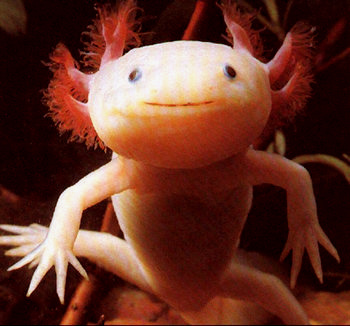

In [9]:
# open the image from ImageNet
axolotl = Image.open("../data/axolotl.JPEG")
axolotl

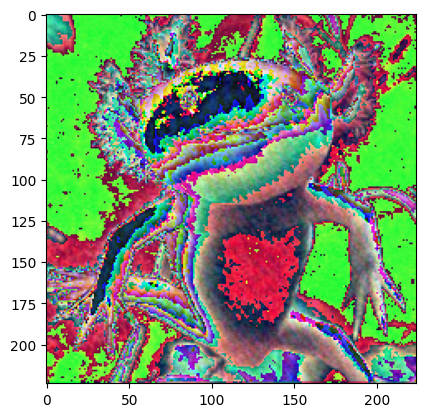

In [10]:
# preprocess the axolotl image from ImageNet
axolotlT = preprocess(axolotl)
plt.imshow(transforms.ToPILImage()(axolotlT))

In [11]:
# use the model to predict for the image
model.eval()
outputA = model(axolotlT.unsqueeze(0).to(device))
probs = torch.nn.Softmax(dim=1)(outputA)
probs.shape

torch.Size([1, 1000])

'29, axolotl'

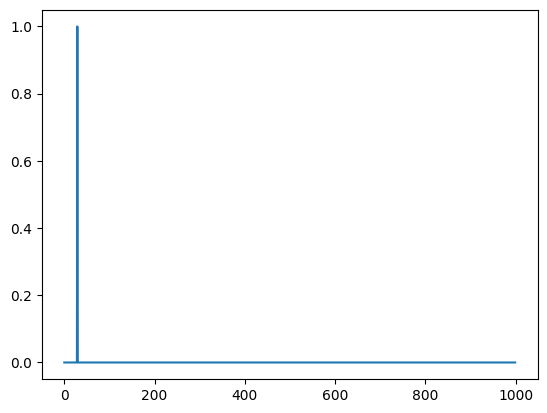

In [12]:
# plot the guess of the model for the image
plt.plot(probs.detach().cpu()[0])
imagenet_labels[probs.argmax()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'489, chainlink_fence'

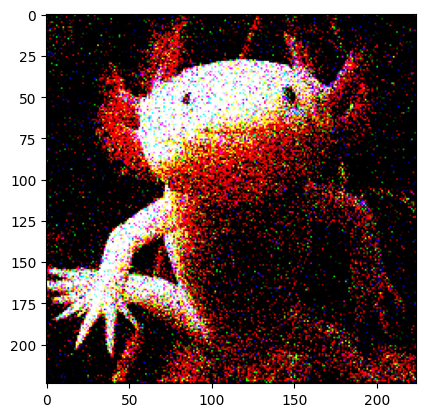

In [13]:
# noise injection to trick the model
noise = np.random.normal(0, 1, axolotlT.unsqueeze(0).size())
noisy = axolotlT.unsqueeze(0) + torch.tensor(noise, dtype=torch.float32)
with torch.no_grad():
    output = model(noisy.to(device))
probs = torch.nn.Softmax(dim=1)(output)
plt.imshow(noisy.squeeze(0).permute(1, 2, 0).numpy())
imagenet_labels[probs.argmax()]

## Part 3: (5 pts)
Now we will retrain the model for CIFAR10. Freeze all of the layers except for the last fully connected layer. Allow this last layer to adapt to the CIFAR10 dataset during the training. Create a validation set and implement an early stopping strategy. Plot the validation accuracy vs epochs and report your selection of hyper-parameters.

In [14]:
# modify the pretrained model's final layer
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(512, 10)
model.fc.requires_grad_ = True

In [15]:
# create the skorch NeuralNetClassifier with EarlyStopping
net = NeuralNetClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    batch_size=128,
    max_epochs=100,
    callbacks=[EarlyStopping(patience=10)],
    lr=0.001,
    optimizer__momentum=0.75,
    device=device
)

In [16]:
# get the inputs
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

In [17]:
# fit and test the model
net.fit(train_images, train_labels)
test_accuracy = net.score(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.5688       0.1538        2.5607  0.4969
      2        2.5461       0.1538        2.5363  0.2803
      3        2.5103       0.1154        2.5125  0.2642
      4        2.4700       0.0769        2.4949  0.2474
      5        2.4306       0.0769        2.4790  0.2537
      6        2.3949       0.0769        2.4626  0.2471
      7        2.3638       0.0769        2.4470  0.2535
      8        2.3368       0.1154        2.4317  0.2505
      9        2.3132       0.2308        2.4177  0.2494
     10        2.2921       0.2692        2.4036  0.2412
     11        2.2726       0.2692        2.3892  0.2432
     12        2.2540       0.3077        2.3748  0.2513
     13        2.2360       0.3462        2.3603  0.2510
     14        2.2181       0.3462        2.3420  0.2510
     15        2.2004       0.3077        2.3254  0.2514
     16        2.1827       0.3

In [18]:
from sklearn.model_selection import GridSearchCV

grid = {
    'lr': [0.1, 0.01, 0.005, 0.001],
    'optimizer__momentum': [0.75, 0.9, 1],
    'max_epochs': [20, 100],
}
gs = GridSearchCV(net, grid, refit=True, cv=4, scoring='accuracy')

# Fit the best model and report best score and parameters
gs.fit(train_images, train_labels)
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1648       0.8500        1.1670  0.1907
      2        0.9680       0.7000        1.0328  0.1807
      3        0.7287       0.6000        1.1114  0.1913
      4        0.5421       0.6500        0.9169  0.1888
      5        0.3408       0.7000        0.8334  0.1909
      6        0.1899       0.7000        0.8942  0.1887
      7        0.1510       0.7000        0.7914  0.1929
      8        0.0884       0.6500        0.7649  0.1985
      9        0.0715       0.6500        0.7575  0.1807
     10        0.0553       0.6500        0.7566  0.1811
     11        0.0410       0.6000        0.7716  0.1834
     12        0.0350       0.6000        0.7812  0.1846
     13        0.0316       0.6000        0.7723  0.1972
     14        0.0275       0.6000        0.7574  0.1990
     15        0.0240       0.6000        0.7481  0.1975
     16        0.0218       0.6

In [19]:
best_model = gs.best_estimator_.module_

In [20]:
test_accuracy = gs.score(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 40.62%


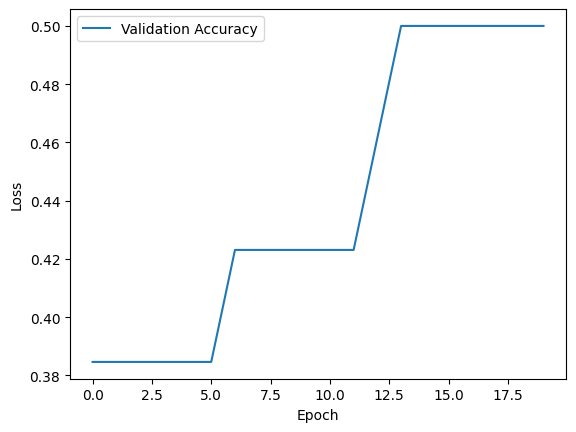

In [21]:
history = gs.best_estimator_.history
plt.figure()
#plt.plot(history[:, 'train_loss'], label='Training Loss')
plt.plot(history[:, 'valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Part 4: (5 pts)
Finally, retrain the network in a similar way as in the previous part. In this case, unfreeze the first convolutional layer and the first convolutional layer present in the first "BasicBlock", in addition to the final fully connected layer. Plot and compare the filters of the first convolutional layer for the original model with the new filters learned after you retrain it. Again, use early stopping on your validation set and plot the validation accuracy vs epochs. Report how you selected your hyperparameters.

In [22]:
# reinitialize the model
model_unfreeze = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
before = model_unfreeze.conv1(train_images[0].unsqueeze(0))[0, 10].detach()
for param in model_unfreeze.parameters():
    param.requires_grad = False
model_unfreeze.fc = torch.nn.Linear(512, 10)

In [23]:
# Unfreeze the first convolutional layer, BB1 conv1, and final fully connected layer
for name, param in model.conv1.named_parameters():
    param.requires_grad = True

for name, param in model.layer1[0].conv1.named_parameters():
    param.requires_grad = True

for name, param in model.fc.named_parameters():
    param.requires_grad = True

In [24]:
# create the skorch NeuralNetClassifier with EarlyStopping
unfrozen_net = NeuralNetClassifier(
    model_unfreeze,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    batch_size=128,
    max_epochs=100,
    callbacks=[EarlyStopping(patience=10)],
    lr=0.005,
    optimizer__momentum=0.9,
    device=device
)

# fit and test the model
unfrozen_net.fit(train_images, train_labels)
test_accuracy_unfreeze = unfrozen_net.score(test_images, test_labels)
print("Test Accuracy:", test_accuracy_unfreeze)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3221       0.2308        2.4406  0.2434
      2        2.2748       0.2308        2.3872  0.2539
      3        2.2020       0.2692        2.3400  0.2509
      4        2.1246       0.2692        2.2959  0.2616
      5        2.0502       0.2692        2.2500  0.2590
      6        1.9751       0.3077        2.2001  0.2503
      7        1.8922       0.3077        2.1423  0.2512
      8        1.7982       0.3077        2.0819  0.2530
      9        1.6942       0.3462        2.0205  0.2513
     10        1.5854       0.3846        1.9614  0.2530
     11        1.4773       0.3846        1.9051  0.2513
     12        1.3739       0.3846        1.8468  0.2508
     13        1.2764       0.3846        1.7878  0.2531
     14        1.1847       0.3846        1.7264  0.2593
     15        1.0981       0.3846        1.6706  0.2519
     16        1.0162       0.3

In [25]:
grid = {
    'lr': [0.01, 0.005, 0.001],
    'optimizer__momentum': [0.75, 0.9, 1],
}
gs_unfreeze = GridSearchCV(unfrozen_net, grid, refit=True, cv=4, scoring='accuracy')

# Fit the best model and report best score and parameters
gs_unfreeze.fit(train_images, train_labels)
print(gs_unfreeze.best_score_, gs_unfreeze.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.1484       1.0000        0.1394  0.1810
      2        0.1473       1.0000        0.1387  0.1908
      3        0.1457       1.0000        0.1382  0.1908
      4        0.1437       1.0000        0.1379  0.1931
      5        0.1416       1.0000        0.1378  0.1910
      6        0.1394       1.0000        0.1376  0.1911
      7        0.1372       1.0000        0.1374  0.1911
      8        0.1348       1.0000        0.1372  0.1928
      9        0.1325       1.0000        0.1369  0.1927
     10        0.1302       1.0000        0.1366  0.1853
     11        0.1278       1.0000        0.1364  0.2022
     12        0.1256       1.0000        0.1362  0.2039
     13        0.1234       1.0000        0.1360  0.1941
     14        0.1212       1.0000        0.1358  0.2005
     15        0.1191       1.0000        0.1357  0.2002
     16        0.1171       1.0

In [26]:
gs.best_estimator_.score(test_images, test_labels)

0.40625

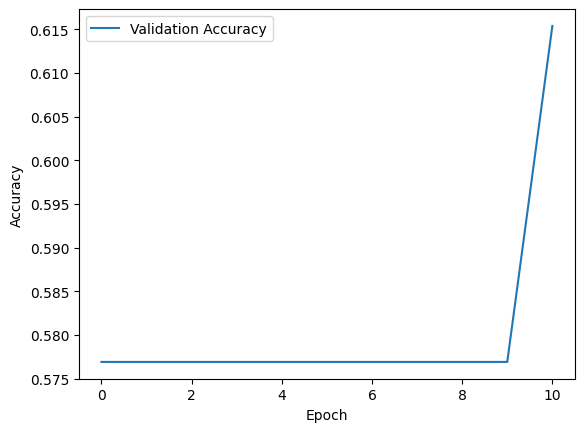

In [27]:
# Plot the validation accuracy vs epoch
history = gs_unfreeze.best_estimator_.history
plt.figure()
#plt.plot(history[:, 'train_loss'], label='Training Loss')
plt.plot(history[:, 'valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

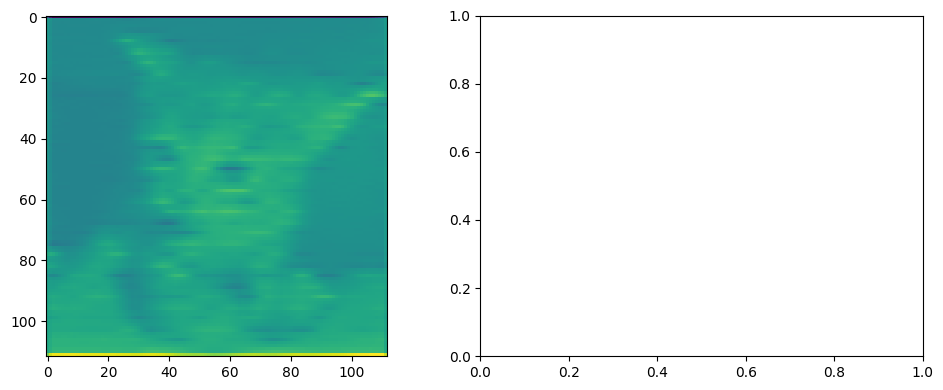

In [29]:
# Compare the filters of the first convolutional layer
fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.tight_layout(h_pad=1, w_pad=0)
axs[0].imshow(before)
axs[1].imshow(model_unfreeze.conv1(train_images[0].unsqueeze(0))[0, 10].detach())